# DoS detection using Network Traffic Classification based on Single Flow Time Series Analysis 

Problem: binary detection of DoS

Raw data from: Bot-IoT [1] & clear data from CESNET2 network

-----------------------------------------------------------------------
[1] Nickolaos Koroniotis et al. Towards the development of realistic botnet dataset in the Internet of Things for network forensic analytics: Bot-IoT dataset. Future Gener. Comput. Syst., 100:779–796, 2019

In [1]:
import pandas as pd
import numpy as np
import json
import collections

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import seaborn as sns

#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

In [2]:
df = pd.read_csv("../cnsm_final_datasets/dos.csv")

In [3]:
df

,Unnamed: 0.1,Unnamed: 0,DST_IP,SRC_IP,PACKETS,PACKETS_REV,BYTES,BYTES_REV,TIME_FIRST,TIME_LAST,...,SPECTRAL_SKEWNESS,SPECTRAL_ROLLOFF,SPECTRAL_CENTROID,SPECTRAL_SPREAD,SPECTRAL_SLOPE,SPECTRAL_CREST,SPECTRAL_FLUX,SPECTRAL_BANDWIDTH,PERIODICITY_SCDF,LABEL
0,0,0,192.168.100.7.,192.168.100.148,5,0,391,0,1.528089e+09,1.528089e+09,...,-313744.025253,0.878615,0.402802,0.209271,NaN,233.222079,602.608368,-0.094367,0.029149,True
1,1,1,192.168.100.7.,192.168.100.148,5,0,389,0,1.528089e+09,1.528089e+09,...,-325241.042104,0.903249,0.325064,0.175965,NaN,173.016423,728.468984,0.068143,0.022841,True
2,2,2,192.168.100.7.,192.168.100.148,5,0,374,0,1.528089e+09,1.528089e+09,...,-292319.976102,0.834709,-1.611567,NaN,NaN,2071.971558,1723.979380,-0.069136,0.008521,True
3,3,3,192.168.100.7.,192.168.100.148,5,0,507,0,1.528089e+09,1.528089e+09,...,-42829.060112,0.783652,0.485833,0.286630,NaN,112.384700,296.101898,-0.017880,0.060085,True
4,4,4,192.168.100.7.,192.168.100.148,5,0,436,0,1.528089e+09,1.528089e+09,...,-225777.997646,0.899673,0.442509,0.252736,NaN,187.074650,401.970775,-0.073308,0.051124,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4009815,4009815,4009815,443,192.168.0.54.5,6,0,3349,0,1.428917e+09,1.428917e+09,...,3441.134454,0.006667,0.511568,0.287497,0.027474,1.077178,0.020648,0.993135,0.999670,False
4009816,4009816,4009816,53176,192.168.0.54.5,11,0,1492,0,1.428917e+09,1.428918e+09,...,-4265.327353,0.276257,0.506199,0.284613,0.011316,1.586032,5.450236,-0.550704,0.492837,False
4009817,4009817,4009817,443,192.168.0.54.5,7,0,4646,0,1.428917e+09,1.428917e+09,...,349038.281575,0.030507,15.857747,NaN,NaN,-140980.501434,176.604046,-0.000199,0.057470,False
4009818,4009818,4009818,53189,192.168.0.54.5,13,0,1891,0,1.428917e+09,1.428918e+09,...,0.539386,0.591939,0.566854,0.272499,0.275930,1.589183,2.146934,0.912873,0.228825,False


In [4]:
print(f"ddos: {len(df[df['LABEL'] == True])}\tclear: {len(df[df['LABEL'] == False])}")

ddos: 60963	clear: 3948857


In [5]:
statistics_features = [
    "MEAN",
    "MEDIAN",
    "STDEV",
    "VAR",
    "BURSTINESS",
    "Q1",
    "Q3",
    "MIN",
    "MAX",
    "MIN_MINUS_MAX",
    "MODE",
    "COEFFICIENT_OF_VARIATION",
    "AVERAGE_DISPERSION",
    "PERCENT_DEVIATION",
    "ROOT_MEAN_SQUARE",
    "PERCENT_BELOW_MEAN",
    "PERCENT_ABOVE_MEAN",
    "PEARSON_SK1_SKEWNESS",
    "PEARSON_SK2_SKEWNESS",
    "FISHER_MI_3_SKEWNESS",
    "FISHER_PEARSON_g1_SKEWNESS",
    "FISHER_PEARSON_G1_SKEWNESS",
    "GALTON_SKEWNESS",
    "KURTOSIS",
    "ENTROPY",
    "SCALED_ENTROPY",
]
distribution_features = [
    "HURST_EXPONENT",
    "BENFORD_LAW_PRESENTED",
    "P_BENFORD",
    "NORMAL_DISTRIBUTION",
    "CNT_DISTRIBUTION",
    "TIME_DISTRIBUTION",
    "AREA_VALUES_DISTRIBUTION",
]
time_features = [
    "MEAN_SCALED_TIME",
    "MEDIAN_SCALED_TIME",
    "Q1_SCALED_TIME",
    "Q3_SCALED_TIME",
    "DURATION",
    "MEAN_DIFFTIMES",
    "MEDIAN_DIFFTIMES",
    "MIN_DIFFTIMES",
    "MAX_DIFFTIMES",
    "MEAN_SCALED_DIFFTIMES",
    ]
behavior_features = [
    "SIG_SPACES",
    "SWITCHING_METRIC",
    "TRANSIENTS",
    "CNT_ZEROS",
    "CNT_NZ_DISTRIBUTION",
    "BIGGEST_CNT_1_SEC",
    "DIRECTIONS",
    "PERIODICITY",
    "VAL",
    "TIME",
]
frequency_features = [
    "MIN_POWER",
    "MAX_POWER",
    "MIN_POWER_FREQ",
    "MAX_POWER_FREQ",
    "SPECTRAL_ENERGY",
    "SPECTRAL_ENTROPY",
    "SPECTRAL_KURTOSIS",
    "SPECTRAL_SKEWNESS",
    "SPECTRAL_ROLLOFF",
    "SPECTRAL_CENTROID",
    "SPECTRAL_SPREAD",
    "SPECTRAL_SLOPE",
    "SPECTRAL_CREST",
    "SPECTRAL_FLUX",
    "SPECTRAL_BANDWIDTH",
    "PERIODICITY_SCDF",
]

features = [
    "MEAN",
    "MEDIAN",
    "STDEV",
    "VAR",
    "BURSTINESS",
    "Q1",
    "Q3",
    "MIN",
    "MAX",
    "MIN_MINUS_MAX",
    "MODE",
    "COEFFICIENT_OF_VARIATION",
    "AVERAGE_DISPERSION",
    "PERCENT_DEVIATION",
    "ROOT_MEAN_SQUARE",
    "PERCENT_BELOW_MEAN",
    "PERCENT_ABOVE_MEAN",
    "PEARSON_SK1_SKEWNESS",
    "PEARSON_SK2_SKEWNESS",
    "FISHER_MI_3_SKEWNESS",
    "FISHER_PEARSON_g1_SKEWNESS",
    "FISHER_PEARSON_G1_SKEWNESS",
    "GALTON_SKEWNESS",
    "KURTOSIS",
    "ENTROPY",
    "SCALED_ENTROPY",
    "HURST_EXPONENT",
    "BENFORD_LAW_PRESENTED",
    "P_BENFORD",
    "NORMAL_DISTRIBUTION",
    "CNT_DISTRIBUTION",
    "TIME_DISTRIBUTION",
    "AREA_VALUES_DISTRIBUTION",
    "MEAN_SCALED_TIME",
    "MEDIAN_SCALED_TIME",
    "Q1_SCALED_TIME",
    "Q3_SCALED_TIME",
    "DURATION",
    "MEAN_DIFFTIMES",
    "MEDIAN_DIFFTIMES",
    "MIN_DIFFTIMES",
    "MAX_DIFFTIMES",
    "MEAN_SCALED_DIFFTIMES",
    "SIG_SPACES",
    "SWITCHING_METRIC",
    "TRANSIENTS",
    "CNT_ZEROS",
    "CNT_NZ_DISTRIBUTION",
    "BIGGEST_CNT_1_SEC",
    "DIRECTIONS",
    "PERIODICITY",
    "VAL",
    "TIME",
    "MIN_POWER",
    "MAX_POWER",
    "MIN_POWER_FREQ",
    "MAX_POWER_FREQ",
    "SPECTRAL_ENERGY",
    "SPECTRAL_ENTROPY",
    "SPECTRAL_KURTOSIS",
    "SPECTRAL_SKEWNESS",
    "SPECTRAL_ROLLOFF",
    "SPECTRAL_CENTROID",
    "SPECTRAL_SPREAD",
    "SPECTRAL_SLOPE",
    "SPECTRAL_CREST",
    "SPECTRAL_FLUX",
    "SPECTRAL_BANDWIDTH",
    "PERIODICITY_SCDF",
]

In [6]:
import sklearn
pd.set_option('display.max_columns', None)

df['LABEL'] = df.LABEL.astype('category')
df["LABEL_code"] = df["LABEL"].cat.codes

bool_features = ["TRANSIENTS", "BENFORD_LAW_PRESENTED", "SIG_SPACES", "PERIODICITY","PERIODICITY_SCDF"]


for F in features:
    if F in bool_features:
        continue
    if F in distribution_features:
        df.loc[df[F].isnull(), F] = 0.5
    else:
        df.loc[df[F].isnull(), F] = 0


for F in bool_features:
    df.loc[df[F].isnull(), F] = False
    df[F] = df[F].astype('bool')

In [7]:
df

,Unnamed: 0.1,Unnamed: 0,DST_IP,SRC_IP,PACKETS,PACKETS_REV,BYTES,BYTES_REV,TIME_FIRST,TIME_LAST,DST_PORT,SRC_PORT,MEAN,MEDIAN,STDEV,VAR,BURSTINESS,Q1,Q3,MIN,MAX,MIN_MINUS_MAX,MODE,COEFFICIENT_OF_VARIATION,AVERAGE_DISPERSION,PERCENT_DEVIATION,ROOT_MEAN_SQUARE,PERCENT_BELOW_MEAN,PERCENT_ABOVE_MEAN,PEARSON_SK1_SKEWNESS,PEARSON_SK2_SKEWNESS,FISHER_MI_3_SKEWNESS,FISHER_PEARSON_g1_SKEWNESS,FISHER_PEARSON_G1_SKEWNESS,GALTON_SKEWNESS,KURTOSIS,ENTROPY,SCALED_ENTROPY,HURST_EXPONENT,BENFORD_LAW_PRESENTED,P_BENFORD,NORMAL_DISTRIBUTION,CNT_DISTRIBUTION,TIME_DISTRIBUTION,AREA_VALUES_DISTRIBUTION,MEAN_SCALED_TIME,MEDIAN_SCALED_TIME,Q1_SCALED_TIME,Q3_SCALED_TIME,DURATION,MEAN_DIFFTIMES,MEDIAN_DIFFTIMES,MIN_DIFFTIMES,MAX_DIFFTIMES,MEAN_SCALED_DIFFTIMES,SIG_SPACES,SWITCHING_METRIC,TRANSIENTS,CNT_ZEROS,CNT_NZ_DISTRIBUTION,BIGGEST_CNT_1_SEC,DIRECTIONS,PERIODICITY,VAL,TIME,MIN_POWER,MAX_POWER,MIN_POWER_FREQ,MAX_POWER_FREQ,POWER_MEAN,POWER_STD,POWER_MODE,SPECTRAL_ENERGY,SPECTRAL_ENTROPY,SPECTRAL_KURTOSIS,SPECTRAL_SKEWNESS,SPECTRAL_ROLLOFF,SPECTRAL_CENTROID,SPECTRAL_SPREAD,SPECTRAL_SLOPE,SPECTRAL_CREST,SPECTRAL_FLUX,SPECTRAL_BANDWIDTH,PERIODICITY_SCDF,LABEL,LABEL_code
0,0,0,192.168.100.7.,192.168.100.148,5,0,391,0,1.528089e+09,1.528089e+09,80,52732,138,60.0,174.859944,30576,0.117816,60.00,60.00,60,451,391,60,126.710104,125,90.579710,208.710805,0.800000,0.200000,0.446071,2.024477,0.604699,3.740753e-08,5.576385e-08,0.000000,2.084944,0.721928,0.310918,0.301789,False,0.477121,0.0,1.0,0.214227,0.812500,3.502377,0.000132,0.000082,1.162747,16.348923,4.087231,0.581348,0.000050,15.186176,0.269142,False,1.000000,False,0.0,1.0,631,1.0,False,0,0.0,-157.771646,31.720354,0.972981,0.878615,0.136009,2.317015,0.16662,680.046116,0.000000,2.161064e+07,-313744.025253,0.878615,0.402802,0.209271,0.000000,233.222079,602.608368,-0.094367,True,True,1
1,1,1,192.168.100.7.,192.168.100.148,5,0,389,0,1.528089e+09,1.528089e+09,80,52734,137,60.0,173.965514,30265,0.118873,60.00,60.00,60,449,389,60,126.982127,124,90.510949,207.846578,0.800000,0.200000,0.442616,2.017641,0.620471,1.519499e-07,2.265136e-07,0.000000,2.099872,0.721928,0.310918,0.301789,False,0.477121,0.0,1.0,0.214224,0.812500,3.502252,0.000373,0.000089,1.162257,16.348542,4.087135,0.581084,0.000089,15.186285,0.269133,False,1.000000,False,0.0,1.0,629,1.0,False,0,0.0,-204.860903,19.097306,0.835107,0.903249,0.110379,2.985574,0.16650,551.892856,0.000000,2.223578e+07,-325241.042104,0.903249,0.325064,0.175965,0.000000,173.016423,728.468984,0.068143,True,True,1
2,2,2,192.168.100.7.,192.168.100.148,5,0,374,0,1.528089e+09,1.528089e+09,80,52736,134,60.0,167.257287,27976,0.110395,60.00,60.00,60,434,374,60,124.818871,119,88.805970,201.373285,0.800000,0.200000,0.442432,2.044754,0.613386,1.709759e-07,2.548758e-07,0.000000,2.100675,0.721928,0.310918,0.301789,False,0.477121,0.0,1.0,0.214242,0.812500,3.502457,0.000143,0.000119,1.163852,16.348169,4.087042,0.581914,0.000024,15.184317,0.269162,False,1.000000,False,0.0,1.0,614,1.0,False,0,0.0,-492.994408,46.269426,0.903845,0.834709,0.022331,7.597926,0.16662,111.655553,0.000000,1.824497e+07,-292319.976102,0.834709,-1.611567,0.000000,0.000000,2071.971558,1723.979380,-0.069136,True,True,1
3,3,3,192.168.100.7.,192.168.100.148,5,0,507,0,1.528089e+09,1.528089e+09,80,52738,161,60.0,226.735529,51410,0.169537,60.00,60.00,60,567,507,60,140.829521,162,100.621118,259.186805,0.800000,0.200000,0.445453,1.865610,0.654226,3.431636e-08,5.115581e-08,0.000000,2.087654,0.721928,0.310918,0.301789,False,0.477121,0.0,1.0,0.214134,0.812500,3.498793,0.000088,0.000066,1.154518,16.339294,4.084823,0.577248,0.000022,15.184776,0.269008,False,1.000000,False,0.0,1.0,747,1.0,False,0,0.0,-23.642932,17.608265,0.801532,0.783652,0.156678,0.630643,0.16664,783.392450,0.000000,3.829273e+06,-42829.060112,0.783652,0.485833,0.286630,0.000000,112.384700,296.101898,-0.017880,True,True,1
4,4,4,192.168.100.7.,192.168.100.148,5,0,436,0,1.528089e+09,1.528089e+09,80,52740,147,60.0,194.984615,38019,0.140312,60.00,60.00,60,496,436,60,132.6425

In [8]:
print(f"ddos: {len(df[df['LABEL'] == True])}\tclear: {len(df[df['LABEL'] == False])}")

ddos: 60963	clear: 3948857


In [9]:
df = df[["LABEL_code"] + features].copy()

In [10]:
df.replace([np.inf], 0, inplace=True)
df.replace([-np.inf], 0, inplace=True)

In [11]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

df = clean_dataset(df)

In [12]:
df.shape

(4009820, 70)

In [13]:
print(f"ddos: {len(df[df['LABEL_code'] == 1])}\tclear: {len(df[df['LABEL_code'] == 0])}")

ddos: 60963	clear: 3948857


In [14]:
df_validation = df.sample(n = 100000)
df_features =  df[~df.isin(df_validation)].dropna()

In [15]:
df_features

,LABEL_code,MEAN,MEDIAN,STDEV,VAR,BURSTINESS,Q1,Q3,MIN,MAX,MIN_MINUS_MAX,MODE,COEFFICIENT_OF_VARIATION,AVERAGE_DISPERSION,PERCENT_DEVIATION,ROOT_MEAN_SQUARE,PERCENT_BELOW_MEAN,PERCENT_ABOVE_MEAN,PEARSON_SK1_SKEWNESS,PEARSON_SK2_SKEWNESS,FISHER_MI_3_SKEWNESS,FISHER_PEARSON_g1_SKEWNESS,FISHER_PEARSON_G1_SKEWNESS,GALTON_SKEWNESS,KURTOSIS,ENTROPY,SCALED_ENTROPY,HURST_EXPONENT,BENFORD_LAW_PRESENTED,P_BENFORD,NORMAL_DISTRIBUTION,CNT_DISTRIBUTION,TIME_DISTRIBUTION,AREA_VALUES_DISTRIBUTION,MEAN_SCALED_TIME,MEDIAN_SCALED_TIME,Q1_SCALED_TIME,Q3_SCALED_TIME,DURATION,MEAN_DIFFTIMES,MEDIAN_DIFFTIMES,MIN_DIFFTIMES,MAX_DIFFTIMES,MEAN_SCALED_DIFFTIMES,SIG_SPACES,SWITCHING_METRIC,TRANSIENTS,CNT_ZEROS,CNT_NZ_DISTRIBUTION,BIGGEST_CNT_1_SEC,DIRECTIONS,PERIODICITY,VAL,TIME,MIN_POWER,MAX_POWER,MIN_POWER_FREQ,MAX_POWER_FREQ,SPECTRAL_ENERGY,SPECTRAL_ENTROPY,SPECTRAL_KURTOSIS,SPECTRAL_SKEWNESS,SPECTRAL_ROLLOFF,SPECTRAL_CENTROID,SPECTRAL_SPREAD,SPECTRAL_SLOPE,SPECTRAL_CREST,SPECTRAL_FLUX,SPECTRAL_BANDWIDTH,PERIODICITY_SCDF
0,1.0,138.0,60.0,174.859944,30576.0,0.117816,60.00,60.00,60.0,451.0,391.0,60.0,126.710104,125.0,90.579710,208.710805,0.800000,0.200000,0.446071,2.024477,0.604699,3.740753e-08,5.576385e-08,0.000000,2.084944,0.721928,0.310918,0.301789,0.0,0.477121,0.0,1.0,0.214227,0.812500,3.502377,0.000132,0.000082,1.162747,16.348923,4.087231,0.581348,0.000050,15.186176,0.269142,0.0,1.000000,0.0,0.0,1.0,631.0,1.0,0.0,0.0,0.0,-157.771646,31.720354,0.972981,0.878615,680.046116,0.000000,2.161064e+07,-313744.025253,0.878615,0.402802,0.209271,0.000000,233.222079,602.608368,-0.094367,1.0
1,1.0,137.0,60.0,173.965514,30265.0,0.118873,60.00,60.00,60.0,449.0,389.0,60.0,126.982127,124.0,90.510949,207.846578,0.800000,0.200000,0.442616,2.017641,0.620471,1.519499e-07,2.265136e-07,0.000000,2.099872,0.721928,0.310918,0.301789,0.0,0.477121,0.0,1.0,0.214224,0.812500,3.502252,0.000373,0.000089,1.162257,16.348542,4.087135,0.581084,0.000089,15.186285,0.269133,0.0,1.000000,0.0,0.0,1.0,629.0,1.0,0.0,0.0,0.0,-204.860903,19.097306,0.835107,0.903249,551.892856,0.000000,2.223578e+07,-325241.042104,0.903249,0.325064,0.175965,0.000000,173.016423,728.468984,0.068143,1.0
2,1.0,134.0,60.0,167.257287,27976.0,0.110395,60.00,60.00,60.0,434.0,374.0,60.0,124.818871,119.0,88.805970,201.373285,0.800000,0.200000,0.442432,2.044754,0.613386,1.709759e-07,2.548758e-07,0.000000,2.100675,0.721928,0.310918,0.301789,0.0,0.477121,0.0,1.0,0.214242,0.812500,3.502457,0.000143,0.000119,1.163852,16.348169,4.087042,0.581914,0.000024,15.184317,0.269162,0.0,1.000000,0.0,0.0,1.0,614.0,1.0,0.0,0.0,0.0,-492.994408,46.269426,0.903845,0.834709,111.655553,0.000000,1.824497e+07,-292319.976102,0.834709,-1.611567,0.000000,0.000000,2071.971558,1723.979380,-0.069136,1.0
3,1.0,161.0,60.0,226.735529,51410.0,0.169537,60.00,60.00,60.0,567.0,507.0,60.0,140.829521,162.0,100.621118,259.186805,0.800000,0.200000,0.445453,1.865610,0.654226,3.431636e-08,5.115581e-08,0.000000,2.087654,0.721928,0.310918,0.301789,0.0,0.477121,0.0,1.0,0.214134,0.812500,3.498793,0.000088,0.000066,1.154518,16.339294,4.084823,0.577248,0.000022,15.184776,0.269008,0.0,1.000000,0.0,0.0,1.0,747.0,1.0,0.0,0.0,0.0,-23.642932,17.608265,0.801532,0.783652,783.392450,0.000000,3.829273e+06,-42829.060112,0.783652,0.485833,0.286630,0.000000,112.384700,296.101898,-0.017880,1.0
4,1.0,147.0,60.0,194.984615,38019.0,0.140312,60.00,60.00,60.0,496.0,436.0,60.0,132.642595,139.0,94.557823,228.217440,0.800000,0.200000,0.446189,1.954000,0.625200,2.697919e-08,4.021821e-08,0.000000,2.084431,0.721928,0.310918,0.301789,0.0,0.477121,0.0,1.0,0.214118,0.812500,3.498479,0.000089,0.000066,1.153209,16.339031,4.084758,0.576593,0.000023,15.185822,0.268985,0.0,1.000000,0.0,0.0,1.0,676.0,1.0,0.0,0.0,0.0,-73.280065,27.167804,0.972981,0.899673,726.121994,0.000000,1.474637e+07,-225777.997646,0.899673,0.442509,0.252736,0.000000,187.074650,401.970775,-0.073308,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [16]:
def get_confusion_matrix(y_test, y_pred):
    # Get and reshape confusion matrix data
    matrix = confusion_matrix(y_test, y_pred)
    percentage_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    return matrix, percentage_matrix

def plot_confusion_matrix(matrix, percentage_matrix, model=""):
    # Build the plot
    fig, ax = plt.subplots(1, 2,figsize=(15,5))
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10}, fmt='g',
                cmap=plt.cm.Greens, linewidths=0.2, ax=ax[0])
    sns.heatmap(percentage_matrix, annot=True, annot_kws={'size':10}, fmt='g',
                cmap=plt.cm.Greens, linewidths=0.2, ax=ax[1])
    # Add labels to the plot
    plt.tick_params(axis='both', which='minor', labelsize=5)
    # tick_marks = np.arange(len(classifications_array)) + 0.5
    # plt.xticks(tick_marks, classifications_array, rotation=85)
    # plt.yticks(tick_marks, classifications_array, rotation=0)
    ax[0].set_xlabel('Predicted label')
    ax[0].set_ylabel('True label')
    ax[0].set_title(f'Absolute Confusion Matrix for {model}')
    ax[1].set_xlabel('Predicted label')
    ax[1].set_ylabel('True label')
    ax[1].set_title(f'Relative Confusion Matrix for {model}')
    # pyplot.savefig("ddos_timeseries_plugin_classification.eps", format="eps")
    plt.show()

In [17]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_absolute_error

def tunne_together_XGBoost_classification(df_tunne, _features, verbose=True):
    X=df_tunne[_features]  # Features
    y=df_tunne['LABEL_code']  # Labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify=y)
    
    def objective(space):
        clf = XGBClassifier(
                        n_estimators = int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                        reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                        colsample_bytree=int(space['colsample_bytree']), 
                        # subsample=int(space['subsample']),
                        # eta=space['eta'],
                            )

        evaluation = [( X_train, y_train), ( X_test, y_test)]

        clf.fit(X_train, y_train,
                eval_set=evaluation, eval_metric="auc",
                early_stopping_rounds=10,verbose=False)

        pred = clf.predict(X_test)
        # accuracy = mean_absolute_error(y_test, pred)
        # accuracy = accuracy_score(y_test, pred)
        accuracy = f1_score(y_test, pred)
        if verbose is True:
            print ("SCORE:", accuracy)
        return {'loss': -accuracy, 'status': STATUS_OK }
    
    space={'max_depth': hp.quniform("max_depth", 5, 30, 2),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 0,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 20, 1),
        'n_estimators': hp.quniform('n_estimators', 80, 400, 20),
        # 'subsample': hp.quniform('subsample', 3, 20, 1),
        # 'eta': hp.quniform('eta', 0.005, 0.3, 0.005),
        'seed': 0
    }
    
    trials = Trials()
    
    best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)
        
    print("The best hyperparameters are : ","\n")
    print(best_hyperparams)
    return best_hyperparams

In [20]:
df_to_tunne = df_features.sample(100000)
best_hyperparams = tunne_together_XGBoost_classification(df_to_tunne, features, verbose=False)

100%|██████████| 100/100 [00:37<00:00,  2.64trial/s, best loss: -0.5302013422818792]
The best hyperparameters are :  

{'colsample_bytree': 0.2639071318500841, 'gamma': 7.135696061068099, 'max_depth': 28.0, 'min_child_weight': 2.0, 'n_estimators': 260.0, 'reg_alpha': 0.0, 'reg_lambda': 0.4563473228001519}


In [21]:

def while_XGBoost_classification_tunned(best_hyperparams, cycles=100):
    X=df_features[features]  # Features
    y=df_features['LABEL_code']  # Labels
    best_results = (0,"",None,None, None)
    i = 0
    print(f"\r{i}", end="")
    for i in range(cycles):
        print(f"\r{i}", end="", flush=True)
        tmp_f1 = 0
        tmp_str = ""
        #Split on train and test
        X_train_a, X_test_a, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y) # 70% training and 30% test
        for F, N in zip(
                [ features], # statistics_features, time_features, distribution_features, frequency_features, behavior_features, 
                [ "All"], # "Statistical-based", "Time-based", "Distribution-based",  "Frequency-based",  "Behavior-based", 
        ):
                X_train = X_train_a[F]
                X_test = X_test_a[F] 
                model = XGBClassifier(
                        n_estimators = int(best_hyperparams['n_estimators']), max_depth = int(best_hyperparams['max_depth']), gamma = best_hyperparams['gamma'],
                        reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
                        colsample_bytree=int(best_hyperparams['colsample_bytree']),
                        # subsample=int(best_hyperparams['subsample']),
                        # eta=best_hyperparams['eta'],
                )
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                accuracy = metrics.accuracy_score(y_test, y_pred)  * 100
                precision = precision_score(y_test, y_pred)  * 100
                recall = recall_score(y_test, y_pred)  * 100
                F1 = f1_score(y_test, y_pred)  * 100
                if N == "All":
                    tmp_str += "\multirow{-6}{*}{\\rotatebox{90}{\centering \\textbf{Our approach}}} & \cellcolor{Gray} \\textbf{All} & \\rowcolor{LigthGray}" 
                    tmp_str += "{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1)
                    tmp_str += "\n"
                    tmp_str += "\hline"
                    tmp_str += "\n"
                    tmp_f1 = F1
                elif N in ["Statistical-based", "Distribution-based", "Behavior-based"]:
                    tmp_str += "& \cellcolor{Gray} \\textbf{"
                    tmp_str += N
                    tmp_str += "} & " 
                    tmp_str += "{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1)
                    tmp_str += "\n"
                    tmp_str += "\cline{2-6}"
                    tmp_str += "\n"
                else:
                    tmp_str += "& \cellcolor{Gray} \\textbf{"
                    tmp_str += N
                    tmp_str += "} & \\rowcolor{LigthGray} " 
                    tmp_str += "{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1)
                    tmp_str += "\n"
                    tmp_str += "\cline{2-6}"
                    tmp_str += "\n"
        if best_results[0] < tmp_f1:
            matrix, percentage_matrix = get_confusion_matrix(y_test, y_pred)
            best_results = (tmp_f1, tmp_str, matrix, percentage_matrix, model)
    print("")
    print("")
    print("")
    print(best_results[0])
    print(best_results[1])
    plot_confusion_matrix(best_results[2], best_results[3], model="XGBoost")
    return best_results[4]

9


99.95793016407235
\multirow{-6}{*}{\rotatebox{90}{\centering \textbf{Our approach}}} & \cellcolor{Gray} \textbf{All} & \rowcolor{LigthGray}100.00 & 99.99 & 99.92 & 99.96 \\
\hline



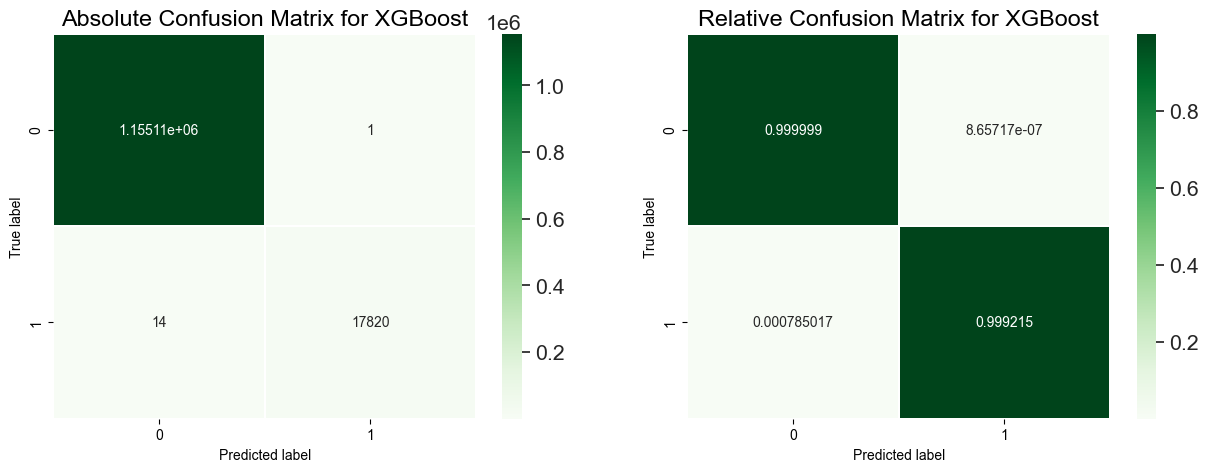

In [22]:
best_model = while_XGBoost_classification_tunned(best_hyperparams, cycles=10)

## Evaluation

\multirow{-6}{*}{\rotatebox{90}{\centering \textbf{Our approach}}} & \cellcolor{Gray} \textbf{All} & \rowcolor{LigthGray}100.00 & 100.00 & 99.87 & 99.93 \\
\hline



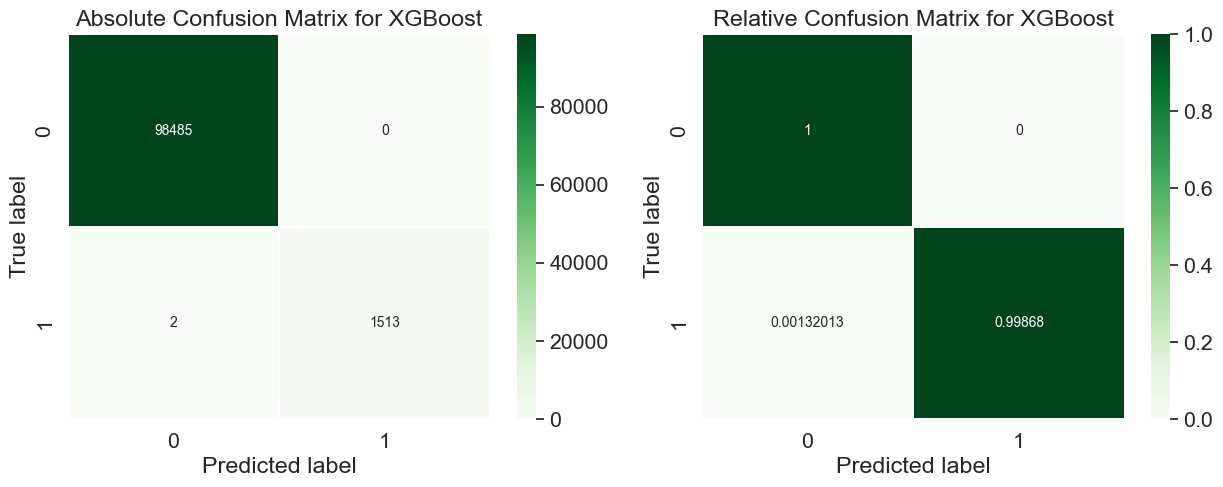

In [23]:
X_validation=df_validation[features]  # Features
y_validation=df_validation['LABEL_code']  # Labels
    

y_pred = best_model.predict(X_validation)
accuracy = metrics.accuracy_score(y_validation, y_pred)  * 100
precision = precision_score(y_validation, y_pred)  * 100
recall = recall_score(y_validation, y_pred)  * 100
F1 = f1_score(y_validation, y_pred)  * 100
                
tmp_str = ""
tmp_str += "\multirow{-6}{*}{\\rotatebox{90}{\centering \\textbf{Our approach}}} & \cellcolor{Gray} \\textbf{All} & \\rowcolor{LigthGray}" 
tmp_str += "{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1)
tmp_str += "\n"
tmp_str += "\hline"
tmp_str += "\n"
print(tmp_str)

matrix, percentage_matrix = get_confusion_matrix(y_validation, y_pred)
plot_confusion_matrix(matrix, percentage_matrix, model="XGBoost")

In [29]:
import csv

problem = "DoS"
with open("feature_reduction_results.csv", "a") as f:
    writer = csv.writer(f)
    writer.writerow([problem, "-", accuracy, precision, recall, F1, 0, 0, 0])

# Feature importance

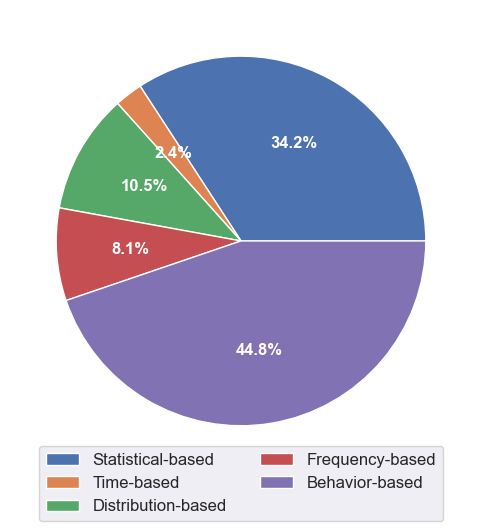

In [24]:
feat_importances = pd.Series(best_model.feature_importances_, index = X_validation.columns).sort_values(ascending = True)

f_sf = feat_importances[statistics_features].sum()
f_tf = feat_importances[time_features].sum()
f_df = feat_importances[distribution_features].sum()
f_ff = feat_importances[frequency_features].sum()
f_bf = feat_importances[behavior_features].sum()

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
data = [f_sf, f_tf, f_df, f_ff, f_bf]
ingredients = ["Statistical-based", "Time-based", "Distribution-based",  "Frequency-based",  "Behavior-based"]
def func(pct, allvals):
    return "{:.1f}%".format(pct)
wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))
ax.legend(wedges, ingredients,
          loc="center",
          bbox_to_anchor=(0.5, 0, 0, -0.05),
          prop={'size': 12},
          ncol=2)
plt.setp(autotexts, size=12, weight="bold")
plt.show()

In [25]:
data

[0.34191766, 0.024488715, 0.10490872, 0.080934174, 0.44775066]

In [26]:
feat_importances

MEAN                0.000000
TIME                0.000000
CNT_ZEROS           0.000000
MAX_POWER_FREQ      0.000000
BURSTINESS          0.000000
                      ...   
CNT_DISTRIBUTION    0.042615
P_BENFORD           0.057364
MIN                 0.068645
Q1                  0.154302
DIRECTIONS          0.379166
Length: 69, dtype: float32

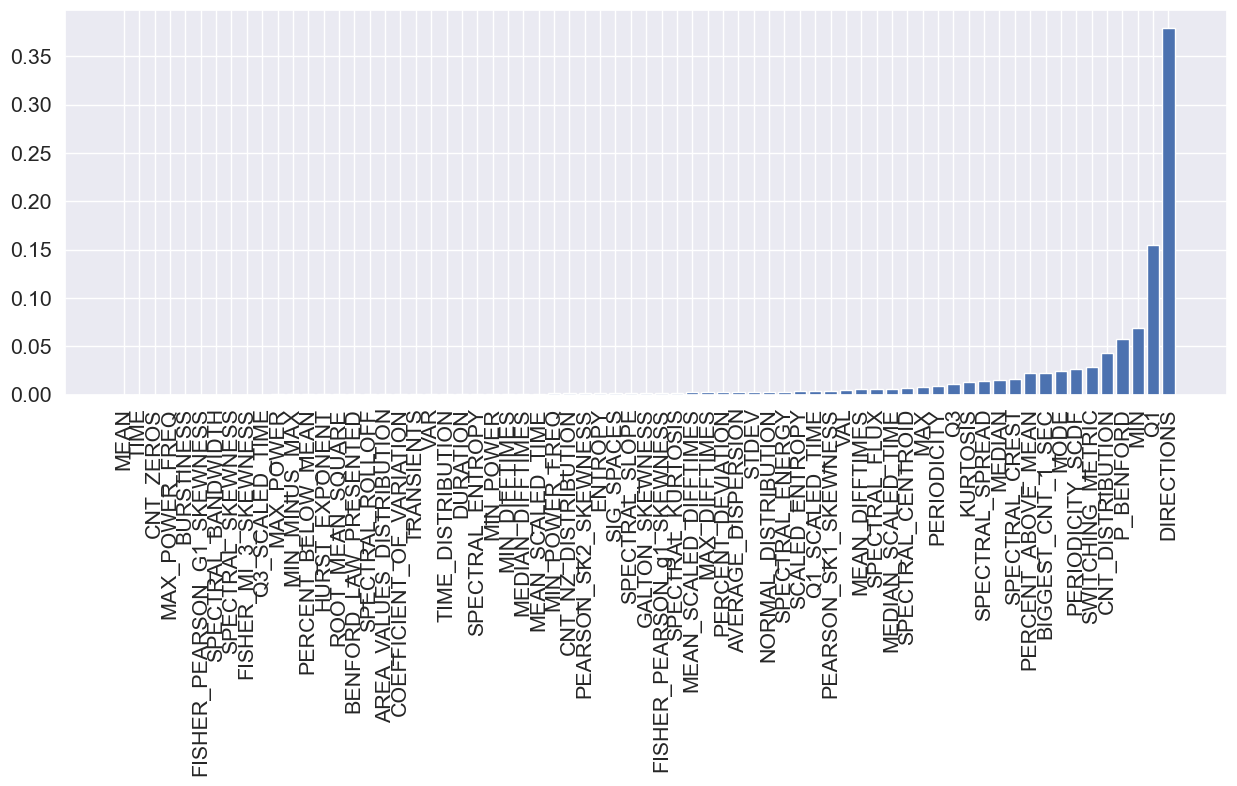

In [27]:
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(feat_importances.keys(), feat_importances.values)
plt.xticks(rotation = 90)
plt.show()

In [28]:
feat_importances.to_dict()

{'MEAN': 0.0,
 'TIME': 0.0,
 'CNT_ZEROS': 0.0,
 'MAX_POWER_FREQ': 0.0,
 'BURSTINESS': 0.0,
 'FISHER_PEARSON_G1_SKEWNESS': 0.0,
 'SPECTRAL_BANDWIDTH': 0.0,
 'SPECTRAL_SKEWNESS': 0.0,
 'FISHER_MI_3_SKEWNESS': 0.0,
 'Q3_SCALED_TIME': 0.0,
 'MAX_POWER': 0.00022561535297427326,
 'MIN_MINUS_MAX': 0.0002872903423849493,
 'PERCENT_BELOW_MEAN': 0.00028834654949605465,
 'HURST_EXPONENT': 0.00031865498749539256,
 'ROOT_MEAN_SQUARE': 0.00042035794467665255,
 'BENFORD_LAW_PRESENTED': 0.0004552518075797707,
 'SPECTRAL_ROLLOFF': 0.00046552307321690023,
 'AREA_VALUES_DISTRIBUTION': 0.0004739263094961643,
 'COEFFICIENT_OF_VARIATION': 0.000503810471855104,
 'TRANSIENTS': 0.0006507473299279809,
 'VAR': 0.0007091192528605461,
 'TIME_DISTRIBUTION': 0.0007223737775348127,
 'DURATION': 0.0007495176396332681,
 'SPECTRAL_ENTROPY': 0.0007908997940830886,
 'MIN_POWER': 0.0009815796511247754,
 'MIN_DIFFTIMES': 0.0010421995539218187,
 'MEDIAN_DIFFTIMES': 0.0010627275332808495,
 'MEAN_SCALED_TIME': 0.00118288025259

# Feature selection

In [18]:
def perform_val(selected_features, best_hyperparams=None, cycles=10):
    if best_hyperparams is None:
        best_hyperparams = tunne_together_XGBoost_classification(df_features.sample(100000), selected_features, verbose=False)
    
    X=df_features[selected_features]  # Features
    y=df_features['LABEL_code']  # Labels

    best = 0
    best_model = None
    for i in range(0, cycles):    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y) # 70% training and 30% test   
        model = XGBClassifier(
            n_estimators = int(best_hyperparams['n_estimators']), max_depth = int(best_hyperparams['max_depth']), gamma = best_hyperparams['gamma'],
            reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
            colsample_bytree=int(best_hyperparams['colsample_bytree']),
        )
        model.fit(X_train, y_train)                
        y_pred = model.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, y_pred)  * 100
        precision = precision_score(y_test, y_pred)  * 100
        recall = recall_score(y_test, y_pred)  * 100
        F1 = f1_score(y_test, y_pred)  * 100
        if F1 > best:   
            best = F1
            best_model = model
            
    
    X_validation=df_validation[selected_features]  # Features
    y_validation=df_validation['LABEL_code']  # Labels

    y_pred = best_model.predict(X_validation)
    accuracy = metrics.accuracy_score(y_validation, y_pred)  * 100
    precision = precision_score(y_validation, y_pred)  * 100
    recall = recall_score(y_validation, y_pred)  * 100
    F1 = f1_score(y_validation, y_pred)  * 100
    
    return accuracy,precision,recall,F1

In [19]:
import FEATURE_REDUCTED as FR
REPORTS = []

report = perform_val(FR.without_flow_header(FR.botnet_best_features))
REPORTS.append(report)
report = perform_val(FR.without_flow_header(FR.doh_best_features))
REPORTS.append(report)
report = perform_val(FR.without_flow_header(FR.dos_best_features))
REPORTS.append(report)
report = perform_val(FR.without_flow_header(FR.dns_malware_features))
REPORTS.append(report)
report = perform_val(FR.without_flow_header(FR.tor_features))
REPORTS.append(report)
report = perform_val(FR.without_flow_header(FR.vpn_features))
REPORTS.append(report)
report = perform_val(FR.without_flow_header(FR.all_best_features))
REPORTS.append(report)
report = perform_val(FR.without_flow_header(FR.combo_features))
REPORTS.append(report)
report = perform_val(FR.without_flow_header(FR.combo_2_features))
REPORTS.append(report)
report = perform_val(FR.without_flow_header(FR.crypto_features))
REPORTS.append(report)

100%|██████████| 100/100 [00:39<00:00,  2.52trial/s, best loss: -0.9663409337676439]
The best hyperparameters are :  

{'colsample_bytree': 0.015018147458956216, 'gamma': 1.1882122634590884, 'max_depth': 10.0, 'min_child_weight': 20.0, 'n_estimators': 140.0, 'reg_alpha': 1.0, 'reg_lambda': 0.11183740718596905}
100%|██████████| 100/100 [00:20<00:00,  4.88trial/s, best loss: -0.7362637362637362]
The best hyperparameters are :  

{'colsample_bytree': 0.1765897313091065, 'gamma': 3.3731328276309545, 'max_depth': 16.0, 'min_child_weight': 10.0, 'n_estimators': 180.0, 'reg_alpha': 0.0, 'reg_lambda': 0.3281057119053379}
100%|██████████| 100/100 [00:39<00:00,  2.56trial/s, best loss: -0.9271676300578033]
The best hyperparameters are :  

{'colsample_bytree': 0.7022828306619356, 'gamma': 4.0978281686169105, 'max_depth': 10.0, 'min_child_weight': 11.0, 'n_estimators': 260.0, 'reg_alpha': 2.0, 'reg_lambda': 0.7989693325334363}
100%|██████████| 100/100 [00:41<00:00,  2.39trial/s, best loss: -0.944

In [20]:
import csv

problem = "DoS"
with open("feature_reduction_results.csv", "a") as f:
    writer = csv.writer(f)
    for report, f_set in zip(REPORTS, FR.FEATURE_SETS):
        writer.writerow([problem, f_set, report[0], report[1], report[2], report[3], 0, 0, 0])